In [2]:
#Metadados
__author__ = "Luidy"
__version__ = "1.1.0"
__status__ = "corrigindo filtragem de colunas"

#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Configuração visual
sns.set(style="whitegrid")

In [3]:
#definindo função para fins melhor vizualização dos resultados
def linha():
    print('-'*60)
    print()

In [4]:
#carregando dataset
arquivo = 'synthea-pt150k-lc-data-sel-convert.csv'
print("carregando dataset...")
try:
    #df_sujo = dataframe sujo
    df_sujo = pd.read_csv(arquivo, low_memory=False)
    print("Dataset carregado com susseco!")
    linha()
except:
    print("Houve algum problema na importação do dataset")
    raise
print(f"Corpo original do dataframe:{df_sujo.shape}")
df_sujo.head()

carregando dataset...
Dataset carregado com susseco!
------------------------------------------------------------

Corpo original do dataframe:(22811, 788)


,ptnum,label,scc,C-103579009,C-125680007,C-186034007,C-263495000,C-398070004,C-424144002,C-72514-3,...,C-92139-5,C-92140-3,C-92141-1,C-92142-9,C-94040-3,C-979092,C-993452,C-997501,C-999998,C-999999
0,p3818.4,1,165,white,m,nonhispanic,m,massachusetts,50t70,abnormal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p15865,1,150,white,m,nonhispanic,m,massachusetts,gt70,abnormal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p23282.4,1,146,white,m,nonhispanic,m,massachusetts,50t70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p5834.2,1,146,asian,m,hispanic,m,massachusetts,gt70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p27452,1,145,white,m,nonhispanic,m,massachusetts,gt70,normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Criando um dicionario para a tradução posteriormente

print("Selecionando quais melhores atributos para treinamento..")
linha()

mapa_colunas = {
    'label':       'Target',           # 0=Saudável, 1=Câncer
    'C-424144002': 'Idade',            # Faixa Etária
    'C-263495000': 'Genero',           # M/F
    'C-72166-2':   'Fumo',             # Histórico de Fumo
    
    # --- SINAIS VITAIS (Novos) ---
    'C-9279-1':    'Frequencia_Respiratoria', # Vital para pulmão!
    'C-8867-4':    'Frequencia_Cardiaca',
    'C-8480-6':    'Pressao_Sistolica',
    'C-8462-4':    'Pressao_Diastolica',
    
    # --- SINTOMAS & OUTROS ---
    'C-267036007': 'Falta_de_Ar',
    'C-66857006':  'Tosse_com_Sangue',
    'C-39156-5':   'IMC',              
    'C-2708-6':    'Saturacao_Oxigenio',
    'C-49727002':  'Tosse',
    'C-84229001':  'Fadiga',
    'C-7200002':   'Alcoolismo',
    'C-56018004':  'Chiado_no_Peito'
}

#filtrando o dataframe apenas para as colunas que serão utilizadas para o treinamento do modelo
print("Filtrando atributos do dataframe... ")
linha()

colunas_existentes = []
for c in mapa_colunas.keys():
    if c in df_sujo.columns:
        colunas_existentes.append(c)
#df = Dataframe
df = df_sujo[colunas_existentes].rename(columns=mapa_colunas).copy()

print(f"Dimensões atuais do dataframe:{df.shape}")
linha()

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Selecionando quais melhores atributos para treinamento..
------------------------------------------------------------

Filtrando atributos do dataframe... 
------------------------------------------------------------

Dimensões atuais do dataframe:(22811, 16)
------------------------------------------------------------

🔸 Target: [1 0]
🔸 Idade: ['50t70' 'gt70' '30t50']
🔸 Genero: ['m' 'f']
🔸 Fumo: ['former' 'never' nan]
🔸 Frequencia_Respiratoria: ['normal' 'abnormal' nan]
🔸 Frequencia_Cardiaca: ['normal' 'abnormal' nan]
🔸 Pressao_Sistolica: ['normal' 'abnormal' nan]
🔸 Pressao_Diastolica: ['normal' 'abnormal' nan]
🔸 Falta_de_Ar: [nan True]
🔸 Tosse_com_Sangue: [nan True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [nan True]
🔸 Fadiga: [nan True]
🔸 Alcoolismo: [nan True]
🔸 Chiado_no_Peito: [nan True]
----------------------------------------


In [6]:
#traduzindo valores categoricos do dataframe para portugues

if "Fumo" in df.columns:
    df['Fumo'] = df['Fumo'].fillna('Fumante')
    df["Fumo"] = df["Fumo"].replace({'never':'Nao_fumante','former':'Ex_fumante'})

if "Idade" in df.columns:
    df["Idade"] = df["Idade"].replace({
        "50t70":"50_a_70_anos",
        "gt70":"Mais_de_70",
        "30t50":"30_a_50_anos"
    })

if "Genero" in df.columns:
    df["Genero"] = df["Genero"].replace({'m':'M',"f":"F"})


for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' '30_a_50_anos']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nao_fumante' 'Fumante']
🔸 Frequencia_Respiratoria: ['normal' 'abnormal' nan]
🔸 Frequencia_Cardiaca: ['normal' 'abnormal' nan]
🔸 Pressao_Sistolica: ['normal' 'abnormal' nan]
🔸 Pressao_Diastolica: ['normal' 'abnormal' nan]
🔸 Falta_de_Ar: [nan True]
🔸 Tosse_com_Sangue: [nan True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [nan True]
🔸 Fadiga: [nan True]
🔸 Alcoolismo: [nan True]
🔸 Chiado_no_Peito: [nan True]
----------------------------------------
Dimensões atuais do dataframe: (22811, 16)


,Target,Idade,Genero,Fumo,Frequencia_Respiratoria,Frequencia_Cardiaca,Pressao_Sistolica,Pressao_Diastolica,Falta_de_Ar,Tosse_com_Sangue,IMC,Saturacao_Oxigenio,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito
0,1,50_a_70_anos,M,Ex_fumante,normal,normal,normal,normal,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
1,1,Mais_de_70,M,Ex_fumante,normal,normal,normal,normal,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
2,1,50_a_70_anos,M,Ex_fumante,normal,normal,normal,normal,NaN,NaN,abnormal,abnormal,NaN,NaN,NaN,NaN
3,1,Mais_de_70,M,Nao_fumante,normal,normal,normal,normal,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN
4,1,Mais_de_70,M,Nao_fumante,normal,normal,normal,normal,NaN,NaN,abnormal,NaN,NaN,NaN,NaN,NaN


In [7]:
sintomas = [
    'Tosse', 
    'Fadiga', 
    'Falta_de_Ar', 
    'Chiado_no_Peito', 
    'Tosse_com_Sangue',
    'Alcoolismo'
]

# 2. O Loop Mágico
print("Preenchendo vazios com False nos sintomas...")

for col in sintomas:
    # Verifica se a coluna existe para não dar erro
    if col in df.columns:
        df[col] = df[col].fillna(False)

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Preenchendo vazios com False nos sintomas...
🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' '30_a_50_anos']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nao_fumante' 'Fumante']
🔸 Frequencia_Respiratoria: ['normal' 'abnormal' nan]
🔸 Frequencia_Cardiaca: ['normal' 'abnormal' nan]
🔸 Pressao_Sistolica: ['normal' 'abnormal' nan]
🔸 Pressao_Diastolica: ['normal' 'abnormal' nan]
🔸 Falta_de_Ar: [False  True]
🔸 Tosse_com_Sangue: [False  True]
🔸 IMC: ['abnormal' 'normal' nan]
🔸 Saturacao_Oxigenio: [nan 'abnormal']
🔸 Tosse: [False  True]
🔸 Fadiga: [False  True]
🔸 Alcoolismo: [False  True]
🔸 Chiado_no_Peito: [False  True]
----------------------------------------


C:\Users\Luidy\AppData\Local\Temp\ipykernel_20024\2403216472.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False)


In [8]:
coluna_alvo = [
    'Saturacao_Oxigenio',
    'IMC',
    'Frequencia_Respiratoria',
    'Frequencia_Cardiaca',
    'Pressao_Sistolica',
    'Pressao_Diastolica'
]
mapa_correcao = {
    "normal":"Normal",
    "abnormal":"Anormal"
    
}
# 2. O Loop Mágico
print("Preenchendo vazios com False nos sintomas...")

for col in coluna_alvo:
    if col in df.columns:
        df[col] = df[col].fillna("Normal")
        df[col] = df[col].replace(mapa_correcao)


for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

Preenchendo vazios com False nos sintomas...
🔸 Target: [1 0]
🔸 Idade: ['50_a_70_anos' 'Mais_de_70' '30_a_50_anos']
🔸 Genero: ['M' 'F']
🔸 Fumo: ['Ex_fumante' 'Nao_fumante' 'Fumante']
🔸 Frequencia_Respiratoria: ['Normal' 'Anormal']
🔸 Frequencia_Cardiaca: ['Normal' 'Anormal']
🔸 Pressao_Sistolica: ['Normal' 'Anormal']
🔸 Pressao_Diastolica: ['Normal' 'Anormal']
🔸 Falta_de_Ar: [False  True]
🔸 Tosse_com_Sangue: [False  True]
🔸 IMC: ['Anormal' 'Normal']
🔸 Saturacao_Oxigenio: ['Normal' 'Anormal']
🔸 Tosse: [False  True]
🔸 Fadiga: [False  True]
🔸 Alcoolismo: [False  True]
🔸 Chiado_no_Peito: [False  True]
----------------------------------------


In [9]:
#traduzindo as strings para boleano
df = pd.get_dummies(df,drop_first=True)
print("Dummies criados")
print("-"*40)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

Dummies criados
----------------------------------------
Dimensões atuais do dataframe: (22811, 18)


,Target,Falta_de_Ar,Tosse_com_Sangue,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito,Idade_50_a_70_anos,Idade_Mais_de_70,Genero_M,Fumo_Fumante,Fumo_Nao_fumante,Frequencia_Respiratoria_Normal,Frequencia_Cardiaca_Normal,Pressao_Sistolica_Normal,Pressao_Diastolica_Normal,IMC_Normal,Saturacao_Oxigenio_Normal
0,1,False,False,False,False,False,False,True,False,True,False,False,True,True,True,True,False,True
1,1,False,False,False,False,False,False,False,True,True,False,False,True,True,True,True,False,True
2,1,False,False,False,False,False,False,True,False,True,False,False,True,True,True,True,False,False
3,1,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,False,True
4,1,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,False,True


In [10]:
for col in df.columns:
    df[col] = df[col].astype(int)

for i in df.columns:
    print(f"🔸 {i}: {df[i].unique()}")

print("-" * 40)

print(f"Dimensões atuais do dataframe: {df.shape}")
display(df.head().T)

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

🔸 Target: [1 0]
🔸 Falta_de_Ar: [0 1]
🔸 Tosse_com_Sangue: [0 1]
🔸 Tosse: [0 1]
🔸 Fadiga: [0 1]
🔸 Alcoolismo: [0 1]
🔸 Chiado_no_Peito: [0 1]
🔸 Idade_50_a_70_anos: [1 0]
🔸 Idade_Mais_de_70: [0 1]
🔸 Genero_M: [1 0]
🔸 Fumo_Fumante: [0 1]
🔸 Fumo_Nao_fumante: [0 1]
🔸 Frequencia_Respiratoria_Normal: [1 0]
🔸 Frequencia_Cardiaca_Normal: [1 0]
🔸 Pressao_Sistolica_Normal: [1 0]
🔸 Pressao_Diastolica_Normal: [1 0]
🔸 IMC_Normal: [0 1]
🔸 Saturacao_Oxigenio_Normal: [1 0]
----------------------------------------
Dimensões atuais do dataframe: (22811, 18)


,0,1,2,3,4
Target,1,1,1,1,1
Falta_de_Ar,0,0,0,0,0
Tosse_com_Sangue,0,0,0,0,0
Tosse,0,0,0,0,0
Fadiga,0,0,0,0,0
Alcoolismo,0,0,0,0,0
Chiado_no_Peito,0,0,0,0,0
Idade_50_a_70_anos,1,0,1,0,0
Idade_Mais_de_70,0,1,0,1,1
Genero_M,1,1,1,1,1


Dimensões atuais do dataframe: (22811, 18)


,Target,Falta_de_Ar,Tosse_com_Sangue,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito,Idade_50_a_70_anos,Idade_Mais_de_70,Genero_M,Fumo_Fumante,Fumo_Nao_fumante,Frequencia_Respiratoria_Normal,Frequencia_Cardiaca_Normal,Pressao_Sistolica_Normal,Pressao_Diastolica_Normal,IMC_Normal,Saturacao_Oxigenio_Normal
0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,1
1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1
2,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0
3,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1
4,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1


In [11]:
#tratando duplicatas
print("verificando se há duplicatas")

duplicatas= df.duplicated().sum()

print(f"Um total de {duplicatas} foram encontras")
print("Excluindo duplicatas...")
df = df.drop_duplicates()

print(f"Dimensões atuais do dataframe: {df.shape}")
df.head()

verificando se há duplicatas
Um total de 22227 foram encontras
Excluindo duplicatas...
Dimensões atuais do dataframe: (584, 18)


,Target,Falta_de_Ar,Tosse_com_Sangue,Tosse,Fadiga,Alcoolismo,Chiado_no_Peito,Idade_50_a_70_anos,Idade_Mais_de_70,Genero_M,Fumo_Fumante,Fumo_Nao_fumante,Frequencia_Respiratoria_Normal,Frequencia_Cardiaca_Normal,Pressao_Sistolica_Normal,Pressao_Diastolica_Normal,IMC_Normal,Saturacao_Oxigenio_Normal
0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,1
1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1
2,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0
3,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1
5,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0


In [12]:
#definindo dependencias e independencias 
x = df.drop("Target", axis=1)
y = df["Target"]

#definindo variaveis para treinamento e teste
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y,test_size=0.3,random_state=42)
print("Variaveis de treinamento Definidas")
print("-"*40)

#configurando validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("Validação cruzada Configurada")
print("-"*40)

#definindo algoritimos para a comparação de desempenho
algoritimos = {
    "Regressão Logística": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Árvore de Decisão":   DecisionTreeClassifier(class_weight='balanced',random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42),
    "SVM (Support Vector)": SVC(probability=True,class_weight='balanced', random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42)
}
print("Algoritimos para avaliação definidos")
print("-"*40)

Variaveis de treinamento Definidas
----------------------------------------
Validação cruzada Configurada
----------------------------------------
Algoritimos para avaliação definidos
----------------------------------------


In [13]:
# ---------------------------------------------------------
# TORNEIO DE MODELOS: A Decisão Matemática
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix

# 1. Definição das Métricas
# Recall = De todos os doentes, quantos eu achei? (Prioridade Máxima)
# Especificidade = De todos os saudáveis, quantos eu não assustei? (Critério de Desempate)

def calc_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Dicionário de métricas para o cross_validate calcular simultaneamente
scoring_metrics = {
    'recall': 'recall', 
    'specificity': make_scorer(calc_specificity)
}

# 2. Configuração dos Modelos
# Adicione quantos quiser aqui. O código vai testar todos.
modelos_candidatos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM (RBF)":           SVC(kernel='rbf', class_weight='balanced', probability=True),
    "Random Forest":       RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42),
    "Decision Tree":       DecisionTreeClassifier(class_weight='balanced')
}

# 3. Parâmetros do Torneio
margem_empate = 0.02  # 2% (Se a diferença for menor que isso, vamos para o desempate)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(f"🏆 INICIANDO A BATALHA DOS ALGORITMOS...")
print(f"⚙️ Critério 1 (Eliminatório): Maior Recall")
print(f"⚙️ Critério 2 (Desempate):    Maior Especificidade (Verdadeiros Negativos)")
print("-" * 100)
print(f"{'ALGORITMO':<20} | {'RECALL (Média)':<15} | {'ESPECIFICIDADE':<15} | {'ESTABILIDADE (Desvio)'}")
print("-" * 100)

resultados = []

# 4. Execução dos Testes (Validação Cruzada)
for nome, modelo in modelos_candidatos.items():
    # cross_validate calcula TUDO de uma vez em cada um dos 10 folds
    scores = cross_validate(modelo, x_treino, y_treino, cv=kf, scoring=scoring_metrics)
    
    mean_recall = scores['test_recall'].mean()
    mean_spec = scores['test_specificity'].mean()
    std_recall = scores['test_recall'].std()
    
    resultados.append({
        'Nome': nome,
        'Modelo': modelo,
        'Recall': mean_recall,
        'Especificidade': mean_spec,
        'Desvio': std_recall
    })
    
    print(f"{nome:<20} | {mean_recall:.2%}          | {mean_spec:.2%}          | ±{std_recall:.2%}")

print("-" * 100)

# 5. O JUIZ AUTOMÁTICO (Lógica de Decisão)
df_res = pd.DataFrame(resultados)

# Passo A: Quem tem o maior Recall?
melhor_recall_geral = df_res['Recall'].max()

# Passo B: Quem está no "Pelotão de Elite"? (Líder + Empates Técnicos)
# Seleciona todos que estão a menos de 2% de distância do líder
finalistas = df_res[df_res['Recall'] >= (melhor_recall_geral - margem_empate)].copy()

print(f"🔎 ANÁLISE: O maior Recall foi {melhor_recall_geral:.2%}.")
print(f"   Selecionando finalistas com Recall acima de {(melhor_recall_geral - margem_empate):.2%}...")

if len(finalistas) > 1:
    print(f"   ⚔️ EMPATE TÉCNICO DETECTADO entre: {finalistas['Nome'].tolist()}")
    print(f"   -> Aplicando critério de desempate: ESPECIFICIDADE.")
    
    # Passo C: Dentre os finalistas, quem tem a maior Especificidade?
    campeao = finalistas.sort_values(by='Especificidade', ascending=False).iloc[0]
else:
    print(f"   -> Vitória absoluta (sem empate técnico).")
    campeao = finalistas.iloc[0]

# 6. Anúncio do Vencedor
print("\n" + "="*60)
print(f"🥇 VENCEDOR OFICIAL: {campeao['Nome']}")
print("="*60)
print(f"📊 Recall Final:       {campeao['Recall']:.2%} (Capacidade de achar doentes)")
print(f"🛡️ Especificidade:     {campeao['Especificidade']:.2%} (Capacidade de não errar saudáveis)")
print(f"⚖️ Estabilidade:       ±{campeao['Desvio']:.2%}")

# Salva o objeto do modelo vencedor na variável que você vai usar depois
melhor_algoritimo_objeto = campeao['Modelo']
melhor_algoritimo_nome = campeao['Nome']

🏆 INICIANDO A BATALHA DOS ALGORITMOS...
⚙️ Critério 1 (Eliminatório): Maior Recall
⚙️ Critério 2 (Desempate):    Maior Especificidade (Verdadeiros Negativos)
----------------------------------------------------------------------------------------------------
ALGORITMO            | RECALL (Média)  | ESPECIFICIDADE  | ESTABILIDADE (Desvio)
----------------------------------------------------------------------------------------------------
Logistic Regression  | 90.00%          | 89.91%          | ±13.42%
SVM (RBF)            | 90.00%          | 88.79%          | ±13.42%
Random Forest        | 49.00%          | 92.71%          | ±15.78%
Gradient Boosting    | 44.67%          | 94.67%          | ±20.23%
Decision Tree        | 47.00%          | 89.87%          | ±12.69%
----------------------------------------------------------------------------------------------------
🔎 ANÁLISE: O maior Recall foi 90.00%.
   Selecionando finalistas com Recall acima de 88.00%...
   ⚔️ EMPATE TÉCNICO DETECTA

In [14]:
#melhor_algoritimo_nome = ""
#melhor_algoritimo_objeto = None
#melhor_acuracia = 0
#media_comparativa = 0

#print(f"{'ALGORITMO':<25} | {'MÉDIA (CV)':<12} | {'ESTABILIDADE (Desvio)'}")
#print("_"*65)
#cada agoritimo sera treinado e testado 10 vezes com
#for nome, algoritimo in algoritimos.items():
#    scores = cross_val_score(algoritimo,x_treino,y_treino,cv=kfold,scoring='recall')
#
 #   media = scores.mean()
#    desvio = scores.std()
#
#    print(f"{nome:<25} | {media*100:.2f}% | [+/-]{desvio*100:.2f}%")
#
#    if media-desvio > media_comparativa:
#        melhor_algoritimo_nome = nome
#        melhor_algoritimo_objeto = algoritimo
#        melhor_acuracia = media
#        media_comparativa = media - desvio
        
#print("-"*65)
#print(f"Melhor algoritimo: {melhor_algoritimo_nome}")
#print(f"com acuracia media de {melhor_acuracia*100:.2f}%")
    

In [15]:
print(f"Treinando o modelo com {melhor_algoritimo_nome}...")
linha()
modelo = melhor_algoritimo_objeto.fit(x_treino,y_treino)

previsoes = modelo.predict(x_teste)
acuracia = accuracy_score(y_teste,previsoes)

print(f"Modelo hold out com algoritimo {melhor_algoritimo_nome} apresenta precisão de {acuracia*100:.2f}%")
linha()

Treinando o modelo com Logistic Regression...
------------------------------------------------------------

Modelo hold out com algoritimo Logistic Regression apresenta precisão de 89.77%
------------------------------------------------------------



Text(42.25, 0.5, 'Realidade')

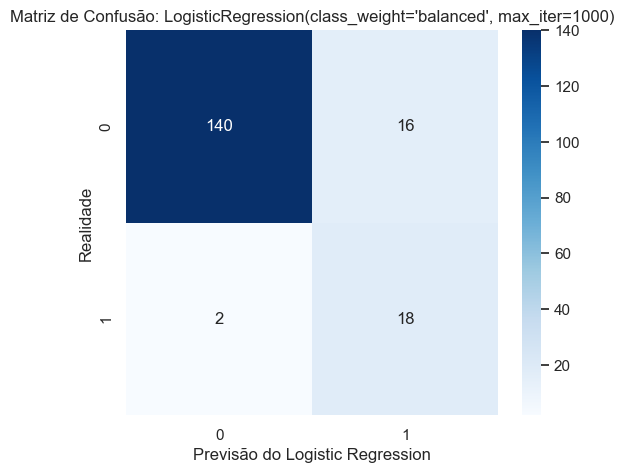

In [17]:
#criando matriz de erro
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_teste, previsoes), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusão: {modelo}")
plt.xlabel(f"Previsão do {melhor_algoritimo_nome}")
plt.ylabel("Realidade")

🕵️‍♂️ Analisando os Coeficientes da Logistic Regression...


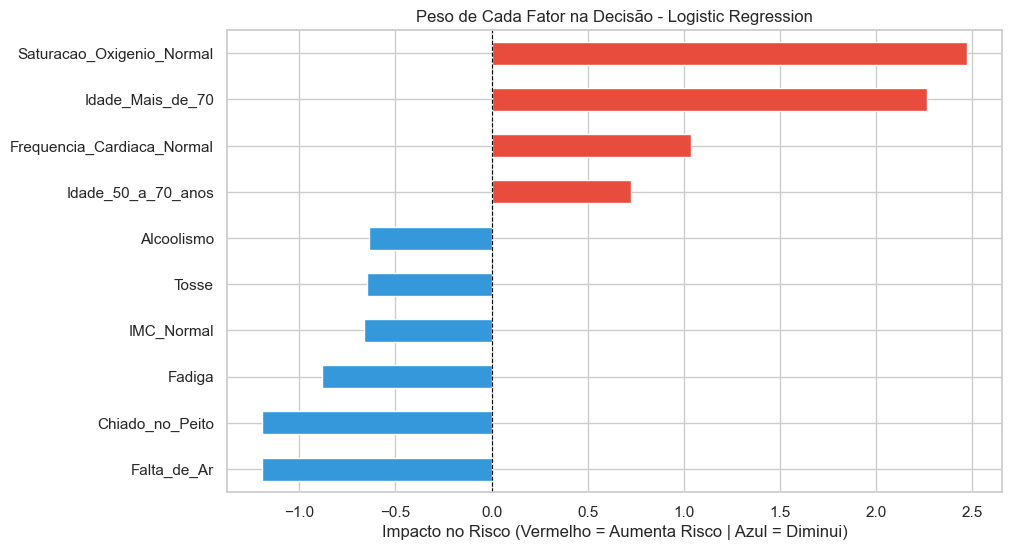


INTERPRETAÇÃO:
-> Barras VERMELHAS (Direita): Fatores que AUMENTAM a chance de Câncer.
-> Barras AZUIS (Esquerda): Fatores que DIMINUEM a chance (Proteção ou Saudável).


In [18]:
# ---------------------------------------------------------
# IMPORTÂNCIA DAS VARIÁVEIS (Específico para Regressão Logística)
# ---------------------------------------------------------
print(f"🕵️‍♂️ Analisando os Coeficientes da {melhor_algoritimo_nome}...")

# 1. Pegar os coeficientes (pesos) do modelo
# coef_[0] pega a lista de pesos para a classe "1" (Câncer)
importancias = pd.Series(modelo.coef_[0], index=x.columns)

# 2. Separar os Top 10 que mais influenciam (positiva ou negativamente)
# Usamos o valor absoluto (abs) para pegar os mais fortes, sejam protetores ou de risco
top_fatores = importancias.abs().nlargest(10).index
subset_importancias = importancias[top_fatores].sort_values()

# 3. Plotar
plt.figure(figsize=(10, 6))

# Cores: Vermelho para Risco (+), Azul para Proteção (-)
cores = ['#e74c3c' if x > 0 else '#3498db' for x in subset_importancias]

subset_importancias.plot(kind='barh', color=cores)

plt.title(f"Peso de Cada Fator na Decisão - {melhor_algoritimo_nome}")
plt.xlabel("Impacto no Risco (Vermelho = Aumenta Risco | Azul = Diminui)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # Linha central
plt.show()

# 4. Explicação em Texto
print("\nINTERPRETAÇÃO:")
print("-> Barras VERMELHAS (Direita): Fatores que AUMENTAM a chance de Câncer.")
print("-> Barras AZUIS (Esquerda): Fatores que DIMINUEM a chance (Proteção ou Saudável).")